In [33]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, MDS
import textwrap

In [34]:
def check_path(path):
    if not path.exists():
        raise FileNotFoundError(f"Directory {str(path)} does not exists!")


dataset = 'imagenet-subset-10k'
# model similarity matrices
model_sim_root_path = Path('/home/space/diverse_priors/model_similarities')
model_sim_path = model_sim_root_path / dataset
check_path(model_sim_path)

# clusterings 
clustering_root_path = Path('/home/space/diverse_priors/clustering/')
clustering_path = clustering_root_path / dataset
check_path(clustering_path)

In [35]:
SAVE = True
storing_path = clustering_path / 'plots' / 'models_filtered_tuned_wd_in1k'

if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [36]:
name_mapping = {
    'cka_kernel_rbf_unbiased_sigma_0.2': 'CKA RBF 0.2',
    'cka_kernel_rbf_unbiased_sigma_0.4': 'CKA RBF 0.4',
    'cka_kernel_rbf_unbiased_sigma_0.6': 'CKA RBF 0.6',
    'cka_kernel_rbf_unbiased_sigma_0.8': 'CKA RBF 0.8',
    'cka_kernel_linear_unbiased': 'CKA linear',
    'rsa_method_correlation_corr_method_pearson': 'RSA pearson',
    'rsa_method_correlation_corr_method_spearman': 'RSA spearman',
}

In [37]:
def get_model_ids(fn):
    with open(fn, 'r') as file:
        lines = file.readlines()
    lines = [line.strip() for line in lines]
    return lines

In [38]:
sim_mats = {}
storing_paths = {}
for sim_method in model_sim_path.rglob("**/similarity_matrix.pt"):
    print(sim_method)
    model_ids_fn = sim_method.parent / 'model_ids.txt'
    if model_ids_fn.exists():
        model_ids = get_model_ids(model_ids_fn)
    else:
        raise FileNotFoundError(f'{str(model_ids_fn)} does not exist.')

    sim_mat = torch.load(sim_method)
    sim_mats[sim_method.parent.name] = pd.DataFrame(sim_mat, index = model_ids, columns=model_ids)
    np.fill_diagonal(sim_mats[sim_method.parent.name].values, 1)

sim_mats = {x:sim_mats[x] for x in name_mapping.keys()}

/home/space/diverse_priors/model_similarities/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.2/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.8/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/rsa_method_correlation_corr_method_spearman/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/cka_kernel_linear_unbiased/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/rsa_method_correlation_corr_method_pearson/similarity_matrix.pt
/home/space/diverse_priors/model_similarities/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.6/similarity_matrix.pt


In [39]:
# Check all matrices have the same index
first_index = next(iter(sim_mats.values())).index
all_same_index = all(df.index.equals(first_index) for df in sim_mats.values())
if not all_same_index:
    raise ValueError('All DataFrames must have the same index.')

In [40]:
# lbl_assignment_methods = ['kmeans', 'discretize', 'cluster_qr']
lbl_assignment_methods = ['cluster_qr']

In [41]:
clustering_labels = {k: {k1:pd.DataFrame(index=first_index) for k1 in lbl_assignment_methods} for k in sim_mats.keys()}

In [42]:
## For each clustering get all cluster_labels.csv
for clust_fn in clustering_path.rglob("**/cluster_labels.csv"):
    
    split_path = str(clust_fn).split("/")
    
    metric_key = split_path[-4]
    num_clusters = split_path[-3]
    lbl_assignment = split_path[-2]
    if lbl_assignment not in lbl_assignment_methods:
        continue
    
    print(clust_fn)
    num_clusters = f"{num_clusters.split('_')[-1]} clusters"
    
    df = pd.read_csv(clust_fn, index_col='Unnamed: 0')
    clustering_labels[metric_key][lbl_assignment].loc[: ,num_clusters] = df['cluster'].astype('category')

/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/num_clusters_6/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/num_clusters_5/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/num_clusters_7/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/num_clusters_4/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.4/num_clusters_3/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.2/num_clusters_6/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/imagenet-subset-10k/cka_kernel_rbf_unbiased_sigma_0.2/num_clusters_5/cluster_qr/cluster_labels.csv
/home/space/diverse_priors/clustering/ima

In [43]:
clustering_labels['cka_kernel_linear_unbiased']['cluster_qr']

,6 clusters,5 clusters,7 clusters,3 clusters,4 clusters
DreamSim_dino_vitb16,3,0,4,0,0
DreamSim_open_clip_vitb32,NaN,NaN,NaN,NaN,NaN
Kakaobrain_Align,5,4,6,2,3
OpenCLIP_EVA01-g-14-plus_merged2b_s11b_b114k,5,4,6,2,3
OpenCLIP_EVA01-g-14_laion400m_s11b_b41k,5,4,6,2,3
...,...,...,...,...,...
vit_huge_patch14_224.orig_in21k,4,3,5,1,2
vit_huge_patch14_clip_224.laion2b,5,4,6,2,3
vit_large_patch14_clip_224.laion2b,5,4,6,2,3
vit_large_patch16_224,5,4,3,2,3


In [44]:
clustering_labels = {
    k:{k1: df[sorted(df.columns.tolist())] for k1, df in sub_dict.items()} for k, sub_dict in clustering_labels.items()}

clustering_labels= { k:{k1: df[~df['3 clusters'].isna()].copy() for k1, df in sub_dict.items()} for k, sub_dict in clustering_labels.items()}

In [45]:
clustering_labels['cka_kernel_linear_unbiased']['cluster_qr'].head()

,3 clusters,4 clusters,5 clusters,6 clusters,7 clusters
DreamSim_dino_vitb16,0,0,0,3,4
Kakaobrain_Align,2,3,4,5,6
OpenCLIP_EVA01-g-14-plus_merged2b_s11b_b114k,2,3,4,5,6
OpenCLIP_EVA01-g-14_laion400m_s11b_b41k,2,3,4,5,6
OpenCLIP_EVA02-B-16_merged2b_s8b_b131k,2,3,4,5,6


In [46]:
available_models = sorted(clustering_labels['cka_kernel_linear_unbiased']['cluster_qr'].index.tolist())

In [47]:
# Get for each similarity metric TSNE embeddings
tsne_embeddings = {}
for key, sim_mat in sim_mats.items():
    tmp = sim_mat.loc[available_models, available_models]
    dissimilarity_mat = 1 - tmp.values
    tsne_embeddings[key] = TSNE(n_components=2, 
                                learning_rate='auto',
                                init='random',
                                perplexity=10, 
                                metric='precomputed',
                                random_state=42
                               ).fit_transform(dissimilarity_mat)

In [48]:
lbl_assignment_method = lbl_assignment_methods[-1]
lbl_assignment_method

'cluster_qr'

In [49]:
lbl_assignment_clustering_labels = {k:sub_dict[lbl_assignment_method] for k, sub_dict in clustering_labels.items()}

In [50]:
n = len(sim_mats.keys())
m = lbl_assignment_clustering_labels['cka_kernel_linear_unbiased'].shape[1]
fig, axs = plt.subplots(nrows=m, ncols=n, figsize=(3*n, 3*m))

for i, (key, embedd) in enumerate(tsne_embeddings.items()):
    for j, col in enumerate(lbl_assignment_clustering_labels[key]):
        lbls = lbl_assignment_clustering_labels[key][col]
        sns.scatterplot(
            x = embedd[:,0],
            y = embedd[:,1],
            hue = lbls,
            palette = 'tab10',
            legend=False,
            s=75,
            ax=axs[j, i],
            alpha=0.6
        )
        if j==0:
            axs[j, i].set_title(f'{name_mapping[key]}', fontsize=16)
        if i == 0:
            axs[j, i].set_ylabel(f'{col}', fontsize=16)
plt.tight_layout()
if SAVE:
    fig.savefig(storing_path / f'tsne_clustering_{lbl_assignment_method}_overview.pdf')
    plt.close(fig)
else:
    plt.show(fig)

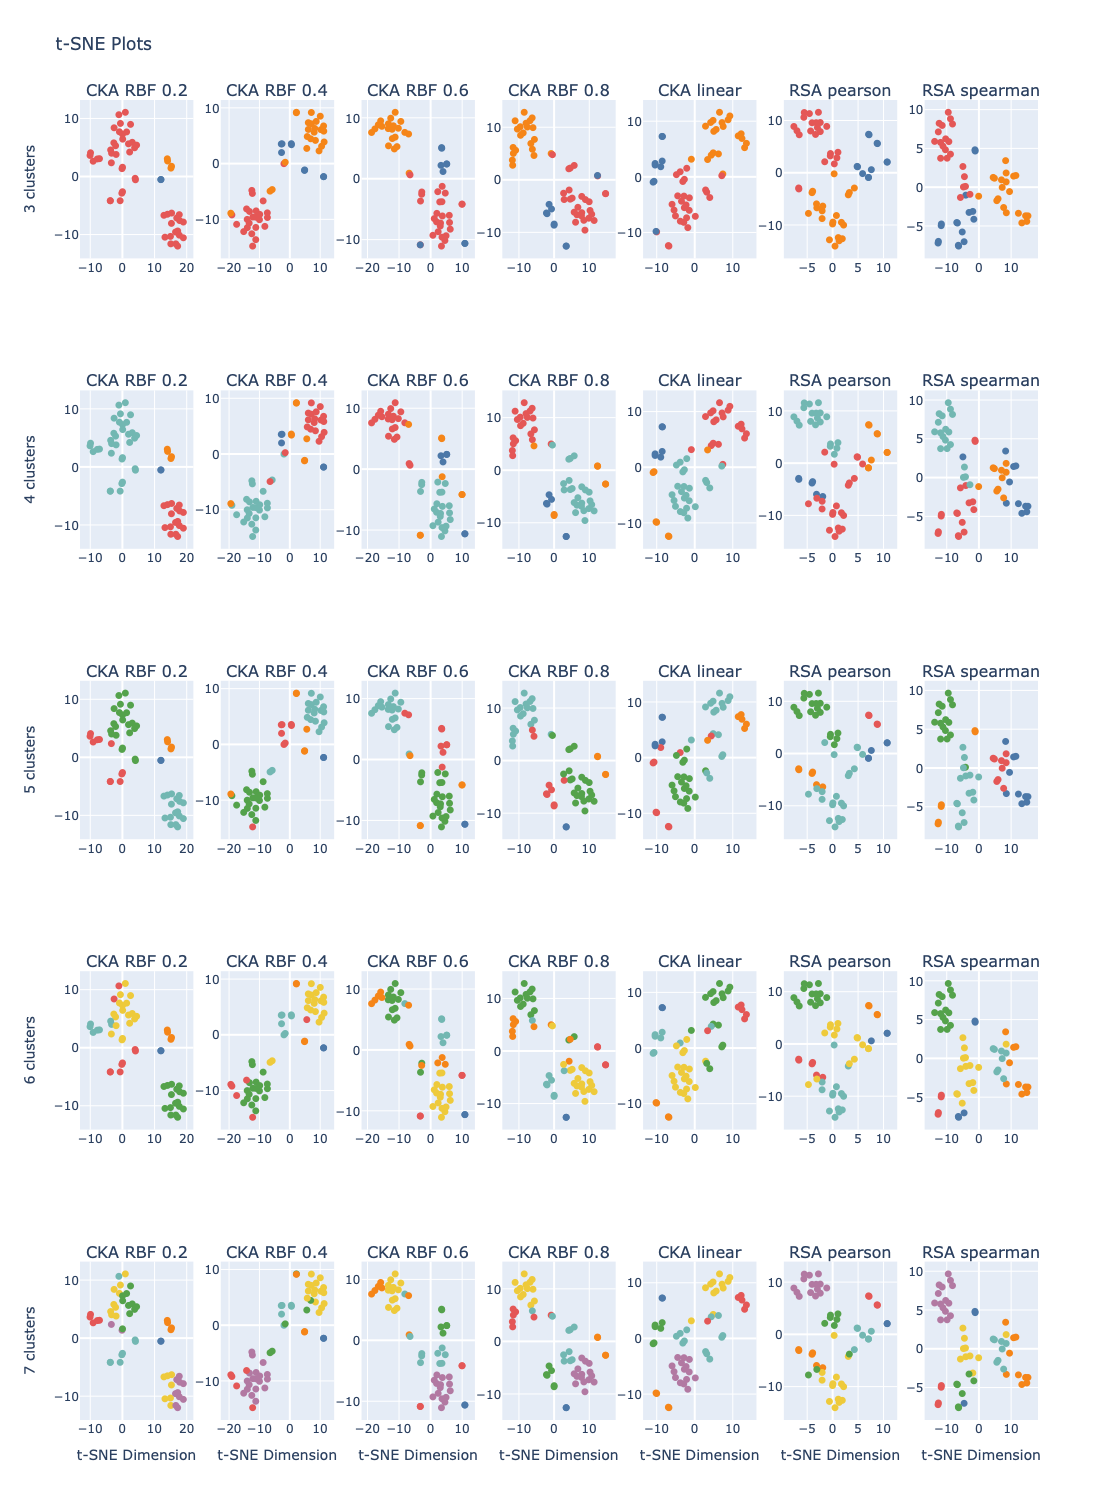

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np
import plotly.express as px

# Define number of rows and columns for the subplots
n = len(sim_mats.keys())
m = lbl_assignment_clustering_labels['cka_kernel_linear_unbiased'].shape[1]

# Create subplot grid
fig = make_subplots(
    rows=m, 
    cols=n,
    subplot_titles=[f'{name_mapping[key]}' for key in tsne_embeddings]*m
)

categories = lbl_assignment_clustering_labels['cka_kernel_rbf_unbiased_sigma_0.2']['7 clusters'].cat.categories.tolist()

color_palette = px.colors.qualitative.T10
label_to_color = {label: color_palette[label] for label in categories}


for i, (key, embedd) in enumerate(tsne_embeddings.items()):
    for j, col in enumerate(lbl_assignment_clustering_labels[key]):
        lbls = lbl_assignment_clustering_labels[key][col]
        colors = [label_to_color[label] for label in lbls]
        scatter = go.Scatter(
            x=embedd[:, 0],
            y=embedd[:, 1],
            mode='markers',
            marker=dict(color=colors,
                        size=7),
            showlegend=False,
            hovertext=lbls.index.tolist()
        )
        fig.add_trace(scatter, row=j+1, col=i+1)
        

# Update axis labels and titles
for i, col in enumerate(lbl_assignment_clustering_labels[key]):
    fig.update_yaxes(title_text=f'{col}', row=i+1, col=1)
    
for i in range(n):
    fig.update_xaxes(title_text='t-SNE Dimension', row=m, col=i+1)

fig.update_layout(height=300*m, width=300*n, title_text="t-SNE Plots", showlegend=False)

if SAVE:
    fig_html = storing_path / f'tsne_clustering_{lbl_assignment_method}_overview.html'
    pio.write_html(fig, file=fig_html, auto_open=True)
fig.show()


In [22]:
for i, (key, embedd) in enumerate(tsne_embeddings.items()):
    curr_storing_path = storing_path / key 
    print(f"Creating single plots for {key} ...")
    for j, col in enumerate(lbl_assignment_clustering_labels[key]):

        lbls = lbl_assignment_clustering_labels[key][col]
        
        ax = sns.scatterplot(
                x = embedd[:,0],
                y = embedd[:,1],
                hue = lbls,
                palette = 'tab10',
                # legend=False,
                s=75,
                alpha=0.6
            )
        curr_df = lbl_assignment_clustering_labels[key].reset_index().groupby(col)
        group_models_spec = curr_df.index.unique()
        lbl_spec = group_models_spec.apply(lambda x: '\n'.join(textwrap.wrap(', '.join(x), width=50)))
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        legend.set_title('Labels')
        for k, label in lbl_spec.items():
            legend.get_texts()[k].set_text(f"{label}")
        
        
        ax.set_title(f"{name_mapping[key]} on {dataset.capitalize()} with {len(lbl_spec)} clusters ({lbl_assignment_method}).")
        if SAVE:
            curr_storing_path.mkdir(parents=True, exist_ok=True)
            plt.savefig(curr_storing_path / f"{col.replace(' ', '_')}_{lbl_assignment_method}.pdf", bbox_inches='tight')
            plt.close()
        else:
            plt.show()

Creating single plots for cka_kernel_rbf_unbiased_sigma_0.2 ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for cka_kernel_rbf_unbiased_sigma_0.4 ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for cka_kernel_rbf_unbiased_sigma_0.6 ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for cka_kernel_rbf_unbiased_sigma_0.8 ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for cka_kernel_linear_unbiased ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for rsa_method_correlation_corr_method_pearson ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Creating single plots for rsa_method_correlation_corr_method_spearman ...


/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2569194/3593201649.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas